In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 256
GAMMA = 0.99
LR_DQN = 0.03
LR_RND = 0.03
EPS = 1e-8
EX_COEF = 1.

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q


class FeatureNet(nn.Module):
    def __init__(self, obs_space):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        out = self.head(x)
        obs_feature = self.fc(out).reshape(out.shape[0], -1)

        return obs_feature

In [4]:
losses = []
f_losses = []


def learn(net, tgt_net, pred_net, rand_net, net_optim, pred_optim, rep_memory):
    global mean
    global std

    net.train()
    tgt_net.train()
    pred_net.train()
    rand_net.train()

    train_data = []
    train_data.extend(random.sample(rep_memory, BATCH_SIZE))

    dataloader = DataLoader(
        train_data,
        batch_size=BATCH_SIZE,
        pin_memory=use_cuda
    )

    # double DQN
    for i, (s, a, r_ex, r_in, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()

        _s_norm = normalize_obs(_s.detach().cpu().numpy(), mean, std)
        _s_norm_batch = torch.tensor([_s_norm]).to(device).float()
        r_ex_batch = r_ex.detach().to(device).float()
        r_in_batch = r_in.detach().to(device).float()
        r_batch = EX_COEF * r_ex_batch + r_in_batch
        is_done = 1. - d.detach().reshape(BATCH_SIZE, 1).to(device).float()

        _q_batch = net(_s_batch)
        _a_batch = torch.argmax(_q_batch, dim=1)
        pred_features = pred_net(_s_norm_batch)

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            action_space = _q_batch_tgt.shape[1]
            done_mask = torch.cat(
                tuple(is_done for _ in range(action_space)), dim=1)
            _q_batch_tgt_masked = _q_batch_tgt * done_mask
            _q_best_tgt = _q_batch_tgt_masked[range(BATCH_SIZE), _a_batch]
            rand_features = rand_net(_s_norm_batch)

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = ((r_batch + GAMMA*_q_best_tgt) - q_acting).pow(2).sum().mean()
        losses.append(loss)
        
        f_loss = (pred_features - rand_features).pow(2).sum(dim=1).mean()
        f_losses.append(f_loss)

        net_optim.zero_grad()
        loss.backward()
        net_optim.step()
        
        pred_optim.zero_grad()
        f_loss.backward()
        pred_optim.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = target_net(state)
        q_np = q.cpu().numpy()[0]
    action = np.argmax(q_np)

    return action


def get_norm_params(obs_memory):
    o = obs_memory[0]
    obs_space = o.shape[0]
    obses = [[] for _ in range(obs_space)]
    for obs in obs_memory:
        for j in range(obs_space):
            obses[j].append(obs[j])

    mean = np.zeros(obs_space, np.float32)
    std = np.zeros(obs_space, np.float32)
    for i, obs_ in enumerate(obses):
        mean[i] = np.mean(obs_)
        std[i] = np.std(obs_)
    return mean, std


def normalize_obs(obs, mean, std):
    batch_size = obs.shape[0]
    means = [mean for _ in range(batch_size)]
    stds = [std for _ in range(batch_size)]
    mean = np.stack(means)
    std = np.stack(stds)
    norm_obs = (obs - mean) / std

    return np.clip(norm_obs, -5, 5)


def calculate_reward_in(pred_net, rand_net, obs):
    global mean
    global std

    norm_obs = normalize_obs(obs, mean, std)
    state = torch.tensor([norm_obs]).to(device).float()
    with torch.no_grad():
        pred_obs = pred_net(state)
        rand_obs = rand_net(state)
        reward = (pred_obs - rand_obs).pow(2).sum()
        clipped_reward = torch.clamp(reward, -1, 1)

    return clipped_reward.item()

In [5]:
# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')
env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n
max_steps = env.spec.max_episode_steps*env.spec.timestep_limit

# hyperparameter
learn_start = env.spec.timestep_limit*5
memory_size = learn_start*20
update_frq = 1
# update_frq = int(env.spec.timestep_limit/10)
# eps_decay = 1. - np.exp(np.log(eps_min)/(max_steps/5))
# epsilon = 1.
eps_min = 0.005
num_eval = 10

# global values
total_steps = 0
learn_steps = 0
mean = None
std = None
rewards = []
reward_eval = deque(maxlen=num_eval)
is_learned = False
is_solved = False

# make four nerual networks
net = DuelingDQN(obs_space, action_space).to(device)
target_net = deepcopy(net)
pred_net = FeatureNet(obs_space).to(device)
rand_net = FeatureNet(obs_space).to(device)

# make optimizer
net_optim = torch.optim.Adam(net.parameters(), lr=LR_DQN, eps=EPS)
pred_optim = torch.optim.Adam(net.parameters(), lr=LR_RND, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)
obs_memory = []

cuda: True
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [6]:
env.spec.max_episode_steps

200

In [7]:
env.spec.reward_threshold

-110.0

In [8]:
env.spec.timestep_limit

200

In [9]:
# play
for i in range(1, env.spec.max_episode_steps+1):
    obs = env.reset()
    done = False
    ep_reward = 0
    ep_reward_in = 0.
    while not done:
        env.render()
        if np.random.rand() < eps_min:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)
        
        if not is_learned:
            obs_memory.append(obs)
            reward_in = 0.
        else:
            reward_in = calculate_reward_in(pred_net, rand_net, _obs)

        rep_memory.append((obs, action, reward, reward_in, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
        ep_reward_in += reward_in
#         epsilon -= epsilon * eps_decay
#         epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n====================  Start Learning  ====================\n')
                is_learned = True
                mean, std = get_norm_params(obs_memory)
                obs_memory.clear()
                
            learn(net, target_net, pred_net, rand_net,
                  net_optim, pred_optim, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            target_net.load_state_dict(net.state_dict())
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}, reward_in {:.2f}'.format(
            i, total_steps, ep_reward, ep_reward_in))

        if len(reward_eval) >= num_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                break
env.close()

  1 Episode in   200 steps, reward -200.00, reward_in 0.00
  2 Episode in   400 steps, reward -200.00, reward_in 0.00
  3 Episode in   600 steps, reward -200.00, reward_in 0.00
  4 Episode in   800 steps, reward -200.00, reward_in 0.00

====================  Start Learning  ====================

  5 Episode in  1000 steps, reward -200.00, reward_in 0.00
  6 Episode in  1200 steps, reward -200.00, reward_in 6.96
  7 Episode in  1400 steps, reward -200.00, reward_in 7.64
  8 Episode in  1600 steps, reward -200.00, reward_in 9.31
  9 Episode in  1800 steps, reward -200.00, reward_in 9.67
 10 Episode in  2000 steps, reward -200.00, reward_in 9.99
 11 Episode in  2200 steps, reward -200.00, reward_in 10.47
 12 Episode in  2400 steps, reward -200.00, reward_in 8.38
 13 Episode in  2600 steps, reward -200.00, reward_in 9.97
 14 Episode in  2800 steps, reward -200.00, reward_in 8.84
 15 Episode in  3000 steps, reward -200.00, reward_in 9.33
 16 Episode in  3189 steps, reward -189.00, reward_in

139 Episode in 26586 steps, reward -200.00, reward_in 10.13
140 Episode in 26786 steps, reward -200.00, reward_in 5.87
141 Episode in 26986 steps, reward -200.00, reward_in 8.42
142 Episode in 27186 steps, reward -200.00, reward_in 8.22
143 Episode in 27386 steps, reward -200.00, reward_in 7.51
144 Episode in 27586 steps, reward -200.00, reward_in 8.54
145 Episode in 27786 steps, reward -200.00, reward_in 10.00
146 Episode in 27986 steps, reward -200.00, reward_in 9.81
147 Episode in 28186 steps, reward -200.00, reward_in 11.81
148 Episode in 28386 steps, reward -200.00, reward_in 11.69
149 Episode in 28586 steps, reward -200.00, reward_in 11.47
150 Episode in 28786 steps, reward -200.00, reward_in 8.83
151 Episode in 28986 steps, reward -200.00, reward_in 12.60
152 Episode in 29186 steps, reward -200.00, reward_in 8.54
153 Episode in 29386 steps, reward -200.00, reward_in 8.02
154 Episode in 29586 steps, reward -200.00, reward_in 10.44
155 Episode in 29786 steps, reward -200.00, rewar

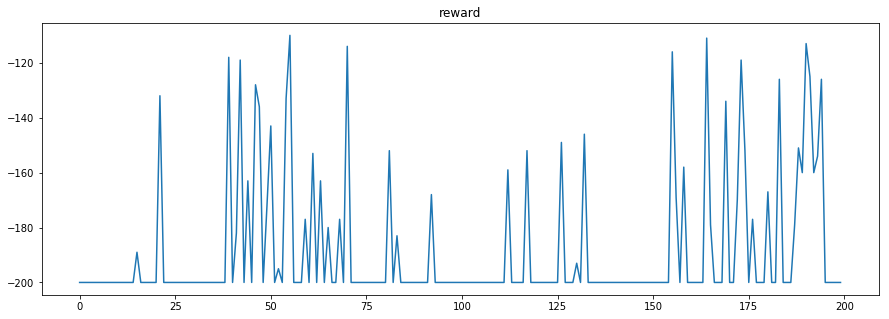

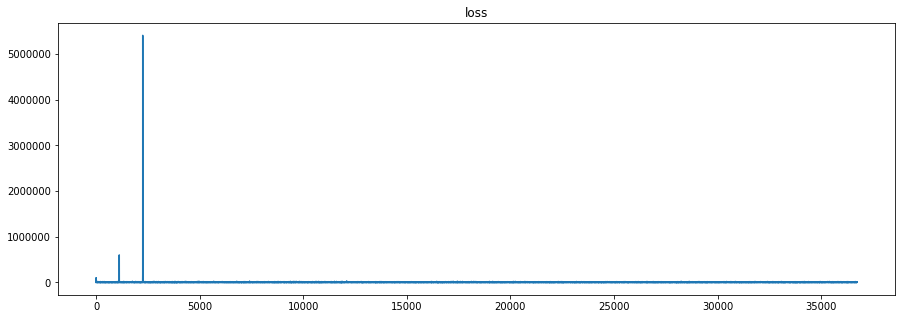

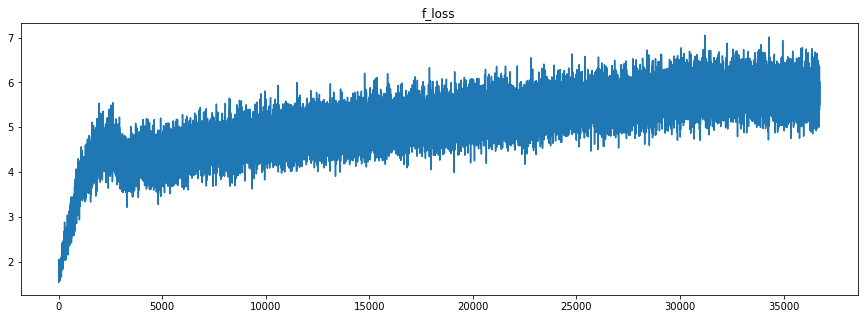

In [10]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('loss')
plt.plot(losses)
plt.show()
plt.figure(figsize=(15, 5))
plt.title('f_loss')
plt.plot(f_losses)
plt.show()